In [3]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [4]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from transformers import (
    AutoTokenizer, AutoModel, AutoConfig,
    get_linear_schedule_with_warmup
)
import numpy as np
import pandas as pd
import time
import psutil
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns
from datasets import load_dataset
import gc
from typing import Dict, List, Tuple
import warnings
warnings.filterwarnings('ignore')

In [5]:
class SentimentDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_length=128):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_length = max_length
    
    def __len__(self):
        return len(self.texts)
    
    def __getitem__(self, idx):
        text = str(self.texts[idx])
        encoding = self.tokenizer(
            text,
            truncation=True,
            padding='max_length',
            max_length=self.max_length,
            return_tensors='pt'
        )
        
        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'labels': torch.tensor(self.labels[idx], dtype=torch.long)
        }


In [6]:
class FullFineTuningClassifier(nn.Module):
    """Standard full fine-tuning approach"""
    def __init__(self, model_name, num_classes=3, dropout_rate=0.1):
        super().__init__()
        self.config = AutoConfig.from_pretrained(model_name)
        self.transformer = AutoModel.from_pretrained(model_name)
        self.dropout = nn.Dropout(dropout_rate)
        self.classifier = nn.Linear(self.config.hidden_size, num_classes)
        
    def forward(self, input_ids, attention_mask):
        outputs = self.transformer(input_ids=input_ids, attention_mask=attention_mask)
        pooled_output = outputs.last_hidden_state[:, 0]  # Use [CLS] token
        pooled_output = self.dropout(pooled_output)
        logits = self.classifier(pooled_output)
        return logits

In [7]:
class LoRAClassifier(nn.Module):
    """Low-Rank Adaptation (LoRA) for parameter-efficient fine-tuning"""
    def __init__(self, model_name, num_classes=3, lora_rank=8, lora_alpha=16):
        super().__init__()
        self.config = AutoConfig.from_pretrained(model_name)
        self.transformer = AutoModel.from_pretrained(model_name)
        self.lora_rank = lora_rank
        self.lora_alpha = lora_alpha
        
        # Freeze all transformer parameters
        for param in self.transformer.parameters():
            param.requires_grad = False
        
        # Add LoRA adapters
        self._add_lora_adapters()
        
        self.dropout = nn.Dropout(0.1)
        self.classifier = nn.Linear(self.config.hidden_size, num_classes)
    
    def _add_lora_adapters(self):
        """Add LoRA adapters to attention layers"""
        # DistilBERT uses 'transformer.layer' instead of 'encoder.layer'
        for layer in self.transformer.transformer.layer:
            # Get attention dimensions
            d_model = layer.attention.q_lin.in_features
            
            # Add LoRA to query and value projections
            layer.attention.lora_q_A = nn.Parameter(torch.randn(d_model, self.lora_rank) * 0.01)
            layer.attention.lora_q_B = nn.Parameter(torch.zeros(self.lora_rank, d_model))
            layer.attention.lora_v_A = nn.Parameter(torch.randn(d_model, self.lora_rank) * 0.01)
            layer.attention.lora_v_B = nn.Parameter(torch.zeros(self.lora_rank, d_model))
            
            # Override forward methods for DistilBERT attention
            original_query_forward = layer.attention.q_lin.forward
            original_value_forward = layer.attention.v_lin.forward
            
            def make_lora_forward(original_forward, lora_A, lora_B):
                def lora_forward(x):
                    original_output = original_forward(x)
                    lora_output = torch.matmul(torch.matmul(x, lora_A), lora_B)
                    return original_output + (self.lora_alpha / self.lora_rank) * lora_output
                return lora_forward
            
            layer.attention.q_lin.forward = make_lora_forward(
                original_query_forward, layer.attention.lora_q_A, layer.attention.lora_q_B
            )
            layer.attention.v_lin.forward = make_lora_forward(
                original_value_forward, layer.attention.lora_v_A, layer.attention.lora_v_B
            )
    
    def forward(self, input_ids, attention_mask):
        outputs = self.transformer(input_ids=input_ids, attention_mask=attention_mask)
        pooled_output = outputs.last_hidden_state[:, 0]
        pooled_output = self.dropout(pooled_output)
        logits = self.classifier(pooled_output)
        return logits


In [8]:

class FrozenBackboneClassifier(nn.Module):
    """Feature extraction: freeze transformer, train only classifier"""
    def __init__(self, model_name, num_classes=3):
        super().__init__()
        self.config = AutoConfig.from_pretrained(model_name)
        self.transformer = AutoModel.from_pretrained(model_name)
        
        # Freeze all transformer parameters
        for param in self.transformer.parameters():
            param.requires_grad = False
        
        # Only train the classifier head
        self.classifier = nn.Sequential(
            nn.Dropout(0.1),
            nn.Linear(self.config.hidden_size, 256),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(256, num_classes)
        )
    
    def forward(self, input_ids, attention_mask):
        with torch.no_grad():
            outputs = self.transformer(input_ids=input_ids, attention_mask=attention_mask)
        pooled_output = outputs.last_hidden_state[:, 0]
        logits = self.classifier(pooled_output)
        return logits

In [9]:
class GradualUnfreezingClassifier(nn.Module):
    """Gradual unfreezing: progressively unfreeze layers during training"""
    def __init__(self, model_name, num_classes=3):
        super().__init__()
        self.config = AutoConfig.from_pretrained(model_name)
        self.transformer = AutoModel.from_pretrained(model_name)
        self.num_layers = len(self.transformer.transformer.layer)
        
        # Initially freeze all transformer parameters
        for param in self.transformer.parameters():
            param.requires_grad = False
        
        self.dropout = nn.Dropout(0.1)
        self.classifier = nn.Linear(self.config.hidden_size, num_classes)
    
    def unfreeze_layers(self, num_layers_to_unfreeze):
        """Unfreeze the top N layers"""
        # Always keep classifier unfrozen
        for param in self.classifier.parameters():
            param.requires_grad = True
            
        # Unfreeze top N transformer layers
        layers_to_unfreeze = self.transformer.transformer.layer[-num_layers_to_unfreeze:]
        for layer in layers_to_unfreeze:
            for param in layer.parameters():
                param.requires_grad = True
    
    def forward(self, input_ids, attention_mask):
        outputs = self.transformer(input_ids=input_ids, attention_mask=attention_mask)
        pooled_output = outputs.last_hidden_state[:, 0]
        pooled_output = self.dropout(pooled_output)
        logits = self.classifier(pooled_output)
        return logits

In [12]:
class SentimentAnalysisExperiment:
    def __init__(self, model_name='distilbert-base-uncased'):
        self.model_name = model_name
        self.tokenizer = AutoTokenizer.from_pretrained(model_name)
        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        self.results = {}
        print(f"Using device: {self.device}")
        
    def load_imdb_dataset(self):
        """Load and prepare the IMDb movie review dataset"""
        print("Loading IMDb dataset...")
        
        # Load dataset
        dataset = load_dataset("imdb")
        
        # Use subset for faster experimentation
        train_size = 5000
        test_size = 1000
        
        train_data = dataset['train'].shuffle(seed=42).select(range(train_size))
        test_data = dataset['test'].shuffle(seed=42).select(range(test_size))
        
        # Prepare data
        train_texts = train_data['text']
        train_labels = train_data['label']  # 0: negative, 1: positive
        
        test_texts = test_data['text']
        test_labels = test_data['label']
        
        # Create validation split from training data
        val_size = int(0.2 * len(train_texts))
        val_texts = train_texts[:val_size]
        val_labels = train_labels[:val_size]
        train_texts = train_texts[val_size:]
        train_labels = train_labels[val_size:]
        
        # Create datasets
        self.train_dataset = SentimentDataset(train_texts, train_labels, self.tokenizer, max_length=256)
        self.val_dataset = SentimentDataset(val_texts, val_labels, self.tokenizer, max_length=256)
        self.test_dataset = SentimentDataset(test_texts, test_labels, self.tokenizer, max_length=256)
        
        print(f"Dataset loaded - Train: {len(self.train_dataset)}, Val: {len(self.val_dataset)}, Test: {len(self.test_dataset)}")
        
        # Show sample data
        print("\nSample reviews:")
        for i in range(2):
            print(f"Label {train_labels[i]} ({'Positive' if train_labels[i] else 'Negative'}): {train_texts[i][:100]}...")
    
    def get_memory_usage(self):
        """Get current memory usage in MB"""
        if torch.cuda.is_available():
            return torch.cuda.memory_allocated() / 1024 / 1024
        else:
            process = psutil.Process()
            return process.memory_info().rss / 1024 / 1024
    
    def count_parameters(self, model):
        """Count total and trainable parameters"""
        total_params = sum(p.numel() for p in model.parameters())
        trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
        return total_params, trainable_params
    
    def train_model(self, model, experiment_name, epochs=3, batch_size=16, lr=2e-5):
        """Train model and collect metrics"""
        print(f"\n{'='*60}")
        print(f"Training: {experiment_name}")
        print(f"{'='*60}")
        
        # Setup data loaders
        train_loader = DataLoader(self.train_dataset, batch_size=batch_size, shuffle=True)
        val_loader = DataLoader(self.val_dataset, batch_size=batch_size)
        test_loader = DataLoader(self.test_dataset, batch_size=batch_size)
        
        model = model.to(self.device)
        
        # Count parameters
        total_params, trainable_params = self.count_parameters(model)
        print(f"Total parameters: {total_params:,}")
        print(f"Trainable parameters: {trainable_params:,}")
        print(f"Trainable ratio: {trainable_params/total_params:.2%}")
        
        # Setup optimizer and scheduler
        optimizer = optim.AdamW([p for p in model.parameters() if p.requires_grad], lr=lr, weight_decay=0.01)
        total_steps = len(train_loader) * epochs
        scheduler = get_linear_schedule_with_warmup(
            optimizer, num_warmup_steps=total_steps//10, num_training_steps=total_steps
        )
        
        criterion = nn.CrossEntropyLoss()
        
        # Training metrics
        metrics = {
            'train_losses': [],
            'val_accuracies': [],
            'epoch_times': [],
            'memory_usage': []
        }
        
        start_time = time.time()
        best_val_acc = 0
        
        for epoch in range(epochs):
            epoch_start = time.time()
            
            # Training phase
            model.train()
            total_loss = 0
            num_batches = 0
            
            for batch in train_loader:
                optimizer.zero_grad()
                
                input_ids = batch['input_ids'].to(self.device)
                attention_mask = batch['attention_mask'].to(self.device)
                labels = batch['labels'].to(self.device)
                
                logits = model(input_ids, attention_mask)
                loss = criterion(logits, labels)
                
                loss.backward()
                torch.nn.utils.clip_grad_norm_([p for p in model.parameters() if p.requires_grad], 1.0)
                optimizer.step()
                scheduler.step()
                
                total_loss += loss.item()
                num_batches += 1
            
            avg_loss = total_loss / num_batches
            metrics['train_losses'].append(avg_loss)
            
            # Validation phase
            model.eval()
            val_preds, val_labels = [], []
            
            with torch.no_grad():
                for batch in val_loader:
                    input_ids = batch['input_ids'].to(self.device)
                    attention_mask = batch['attention_mask'].to(self.device)
                    labels = batch['labels'].to(self.device)
                    
                    logits = model(input_ids, attention_mask)
                    preds = torch.argmax(logits, dim=-1)
                    
                    val_preds.extend(preds.cpu().numpy())
                    val_labels.extend(labels.cpu().numpy())
            
            val_acc = accuracy_score(val_labels, val_preds)
            metrics['val_accuracies'].append(val_acc)
            
            # Track time and memory
            epoch_time = time.time() - epoch_start
            metrics['epoch_times'].append(epoch_time)
            
            current_memory = self.get_memory_usage()
            metrics['memory_usage'].append(current_memory)
            
            print(f"Epoch {epoch+1}/{epochs}:")
            print(f"  Loss: {avg_loss:.4f}")
            print(f"  Val Accuracy: {val_acc:.4f}")
            print(f"  Time: {epoch_time:.1f}s")
            print(f"  Memory: {current_memory:.1f}MB")
            
            if val_acc > best_val_acc:
                best_val_acc = val_acc
            
            # Special handling for gradual unfreezing
            if isinstance(model, GradualUnfreezingClassifier) and epoch < epochs - 1:
                layers_to_unfreeze = min(2, epoch + 1)  # Unfreeze 1-2 layers per epoch
                model.unfreeze_layers(layers_to_unfreeze)
                print(f"  Unfroze top {layers_to_unfreeze} layers")
        
        total_time = time.time() - start_time
        
        # Final test evaluation
        print("\nEvaluating on test set...")
        model.eval()
        test_preds, test_labels_list = [], []
        
        with torch.no_grad():
            for batch in test_loader:
                input_ids = batch['input_ids'].to(self.device)
                attention_mask = batch['attention_mask'].to(self.device)
                labels = batch['labels'].to(self.device)
                
                logits = model(input_ids, attention_mask)
                preds = torch.argmax(logits, dim=-1)
                
                test_preds.extend(preds.cpu().numpy())
                test_labels_list.extend(labels.cpu().numpy())
        
        test_acc = accuracy_score(test_labels_list, test_preds)
        
        # Store comprehensive results
        self.results[experiment_name] = {
            'test_accuracy': test_acc,
            'best_val_accuracy': best_val_acc,
            'final_val_accuracy': metrics['val_accuracies'][-1],
            'total_training_time': total_time,
            'avg_epoch_time': np.mean(metrics['epoch_times']),
            'peak_memory_usage': max(metrics['memory_usage']),
            'total_params': total_params,
            'trainable_params': trainable_params,
            'trainable_ratio': trainable_params/total_params,
            'metrics': metrics,
            'test_predictions': test_preds,
            'test_labels': test_labels_list
        }
        
        print(f"\nFinal Results:")
        print(f"  Test Accuracy: {test_acc:.4f}")
        print(f"  Best Val Accuracy: {best_val_acc:.4f}")
        print(f"  Total Training Time: {total_time:.1f}s")
        print(f"  Peak Memory Usage: {max(metrics['memory_usage']):.1f}MB")
        
        # Cleanup
        del model
        if torch.cuda.is_available():
            torch.cuda.empty_cache()
        gc.collect()
        
        return self.results[experiment_name]
    
    def run_all_experiments(self):
        """Run all fine-tuning experiments"""
        self.load_imdb_dataset()
        
        # Define experiments with different configurations
        experiments = [
            ("Frozen Feature Extraction", FrozenBackboneClassifier(self.model_name, num_classes=2)),
            ("LoRA (r=8)", LoRAClassifier(self.model_name, num_classes=2, lora_rank=8)),
            ("Gradual Unfreezing", GradualUnfreezingClassifier(self.model_name, num_classes=2)),
            ("Full Fine-tuning", FullFineTuningClassifier(self.model_name, num_classes=2))
        ]
        
        for name, model in experiments:
            try:
                self.train_model(model, name, epochs=3, batch_size=16, lr=2e-5)
            except Exception as e:
                print(f"Error in {name}: {e}")
                continue
    
    def analyze_results(self):
        """Comprehensive analysis of results"""
        if not self.results:
            print("No results to analyze. Run experiments first.")
            return
        
        print("\n" + "="*80)
        print("SENTIMENT ANALYSIS FINE-TUNING COMPARISON")
        print("="*80)
        
        # Create comparison table
        comparison_data = []
        for name, results in self.results.items():
            comparison_data.append({
                'Method': name,
                'Test Acc': f"{results['test_accuracy']:.4f}",
                'Best Val Acc': f"{results['best_val_accuracy']:.4f}",
                'Training Time (s)': f"{results['total_training_time']:.1f}",
                'Memory (MB)': f"{results['peak_memory_usage']:.1f}",
                'Trainable Params': f"{results['trainable_params']:,}",
                'Param Ratio': f"{results['trainable_ratio']:.1%}"
            })
        
        df = pd.DataFrame(comparison_data)
        print(df.to_string(index=False))
        
        # Efficiency analysis
        print(f"\n{'='*80}")
        print("TRADE-OFF ANALYSIS")
        print("="*80)
        
        # Find the method with best accuracy-efficiency trade-off
        best_accuracy = max(r['test_accuracy'] for r in self.results.values())
        
        for name, results in self.results.items():
            acc = results['test_accuracy']
            time_ratio = results['total_training_time'] / max(r['total_training_time'] for r in self.results.values())
            memory_ratio = results['peak_memory_usage'] / max(r['peak_memory_usage'] for r in self.results.values())
            param_ratio = results['trainable_ratio']
            
            efficiency_score = acc / (0.4 * time_ratio + 0.3 * memory_ratio + 0.3 * param_ratio)
            
            print(f"\n{name}:")
            print(f"  Accuracy: {acc:.4f} ({(acc/best_accuracy-1)*100:+.1f}%)")
            print(f"  Time Efficiency: {1/time_ratio:.1f}x faster than slowest")
            print(f"  Memory Efficiency: {1/memory_ratio:.1f}x less memory than highest")
            print(f"  Parameter Efficiency: {param_ratio:.1%} parameters trainable")
            print(f"  Overall Efficiency Score: {efficiency_score:.3f}")
        
        # Recommendations
        print(f"\n{'='*80}")
        print("RECOMMENDATIONS")
        print("="*80)
        
        # Sort by different criteria
        best_accuracy_method = max(self.results.items(), key=lambda x: x[1]['test_accuracy'])
        fastest_method = min(self.results.items(), key=lambda x: x[1]['total_training_time'])
        most_memory_efficient = min(self.results.items(), key=lambda x: x[1]['peak_memory_usage'])
        most_param_efficient = min(self.results.items(), key=lambda x: x[1]['trainable_ratio'])
        
        print(f"🎯 Best Accuracy: {best_accuracy_method[0]} ({best_accuracy_method[1]['test_accuracy']:.4f})")
        print(f"⚡ Fastest Training: {fastest_method[0]} ({fastest_method[1]['total_training_time']:.1f}s)")
        print(f"💾 Most Memory Efficient: {most_memory_efficient[0]} ({most_memory_efficient[1]['peak_memory_usage']:.1f}MB)")
        print(f"🔧 Most Parameter Efficient: {most_param_efficient[0]} ({most_param_efficient[1]['trainable_ratio']:.1%})")
        
        print(f"\n📊 Use Case Recommendations:")
        print(f"  • Limited Resources: Choose '{most_memory_efficient[0]}' or '{most_param_efficient[0]}'")
        print(f"  • Quick Prototyping: Choose '{fastest_method[0]}'")
        print(f"  • Production Deployment: Choose '{best_accuracy_method[0]}' if accuracy is critical")
        print(f"  • Balanced Approach: Consider 'LoRA' for good accuracy with efficiency")
        
        return df

        
    def plot_training_curves(self):
        """Plot training curves for comparison"""
        if not self.results:
            return
        
        fig, axes = plt.subplots(2, 2, figsize=(15, 12))
        fig.suptitle('Fine-tuning Methods Comparison', fontsize=16)
        
        # Plot 1: Validation Accuracy
        ax1 = axes[0, 0]
        for name, results in self.results.items():
            epochs = range(1, len(results['metrics']['val_accuracies']) + 1)
            ax1.plot(epochs, results['metrics']['val_accuracies'], marker='o', label=name)
        ax1.set_title('Validation Accuracy')
        ax1.set_xlabel('Epoch')
        ax1.set_ylabel('Accuracy')
        ax1.legend()
        ax1.grid(True)
        
        # Plot 2: Training Loss
        ax2 = axes[0, 1]
        for name, results in self.results.items():
            epochs = range(1, len(results['metrics']['train_losses']) + 1)
            ax2.plot(epochs, results['metrics']['train_losses'], marker='s', label=name)
        ax2.set_title('Training Loss')
        ax2.set_xlabel('Epoch')
        ax2.set_ylabel('Loss')
        ax2.legend()
        ax2.grid(True)
        
        # Plot 3: Memory Usage
        ax3 = axes[1, 0]
        methods = list(self.results.keys())
        memory_usage = [self.results[method]['peak_memory_usage'] for method in methods]
        bars = ax3.bar(methods, memory_usage, color=['skyblue', 'lightcoral', 'lightgreen', 'gold'])
        ax3.set_title('Peak Memory Usage')
        ax3.set_ylabel('Memory (MB)')
        ax3.tick_params(axis='x', rotation=45)
        
        # Add value labels on bars
        for bar in bars:
            height = bar.get_height()
            ax3.text(bar.get_x() + bar.get_width()/2., height,
                    f'{height:.1f}MB', ha='center', va='bottom')
        
        # Plot 4: Accuracy vs Efficiency
        ax4 = axes[1, 1]
        for name, results in self.results.items():
            x = results['trainable_ratio'] * 100  # Percentage of trainable parameters
            y = results['test_accuracy']
            size = 1000 / results['total_training_time']  # Inverse of training time for size
            ax4.scatter(x, y, s=size, alpha=0.7, label=name)
        
        ax4.set_title('Accuracy vs Parameter Efficiency\n(Bubble size ∝ Training Speed)')
        ax4.set_xlabel('Trainable Parameters (%)')
        ax4.set_ylabel('Test Accuracy')
        ax4.legend()
        ax4.grid(True)
        
        plt.tight_layout()
        plt.show()


Using device: cuda
Starting sentiment analysis fine-tuning experiments...
Loading IMDb dataset...
Dataset loaded - Train: 4000, Val: 1000, Test: 1000

Sample reviews:
Label 1 (Positive): Go see this movie for the gorgeous imagery of Andy Goldsworthy's sculptures, and treat yourself to a...
Label 1 (Positive): There is no doubt that during the decade of the 30s, the names of Boris Karloff and Bela Lugosi beca...

Training: Frozen Feature Extraction
Total parameters: 66,560,258
Trainable parameters: 197,378
Trainable ratio: 0.30%
Epoch 1/3:
  Loss: 0.6814
  Val Accuracy: 0.7790
  Time: 23.1s
  Memory: 1099.8MB
Epoch 2/3:
  Loss: 0.6554
  Val Accuracy: 0.7980
  Time: 23.2s
  Memory: 1099.8MB
Epoch 3/3:
  Loss: 0.6412
  Val Accuracy: 0.7940
  Time: 23.2s
  Memory: 1099.8MB

Evaluating on test set...

Final Results:
  Test Accuracy: 0.7800
  Best Val Accuracy: 0.7980
  Total Training Time: 69.5s
  Peak Memory Usage: 1099.8MB

Training: LoRA (r=8)
Total parameters: 66,511,874
Trainable param

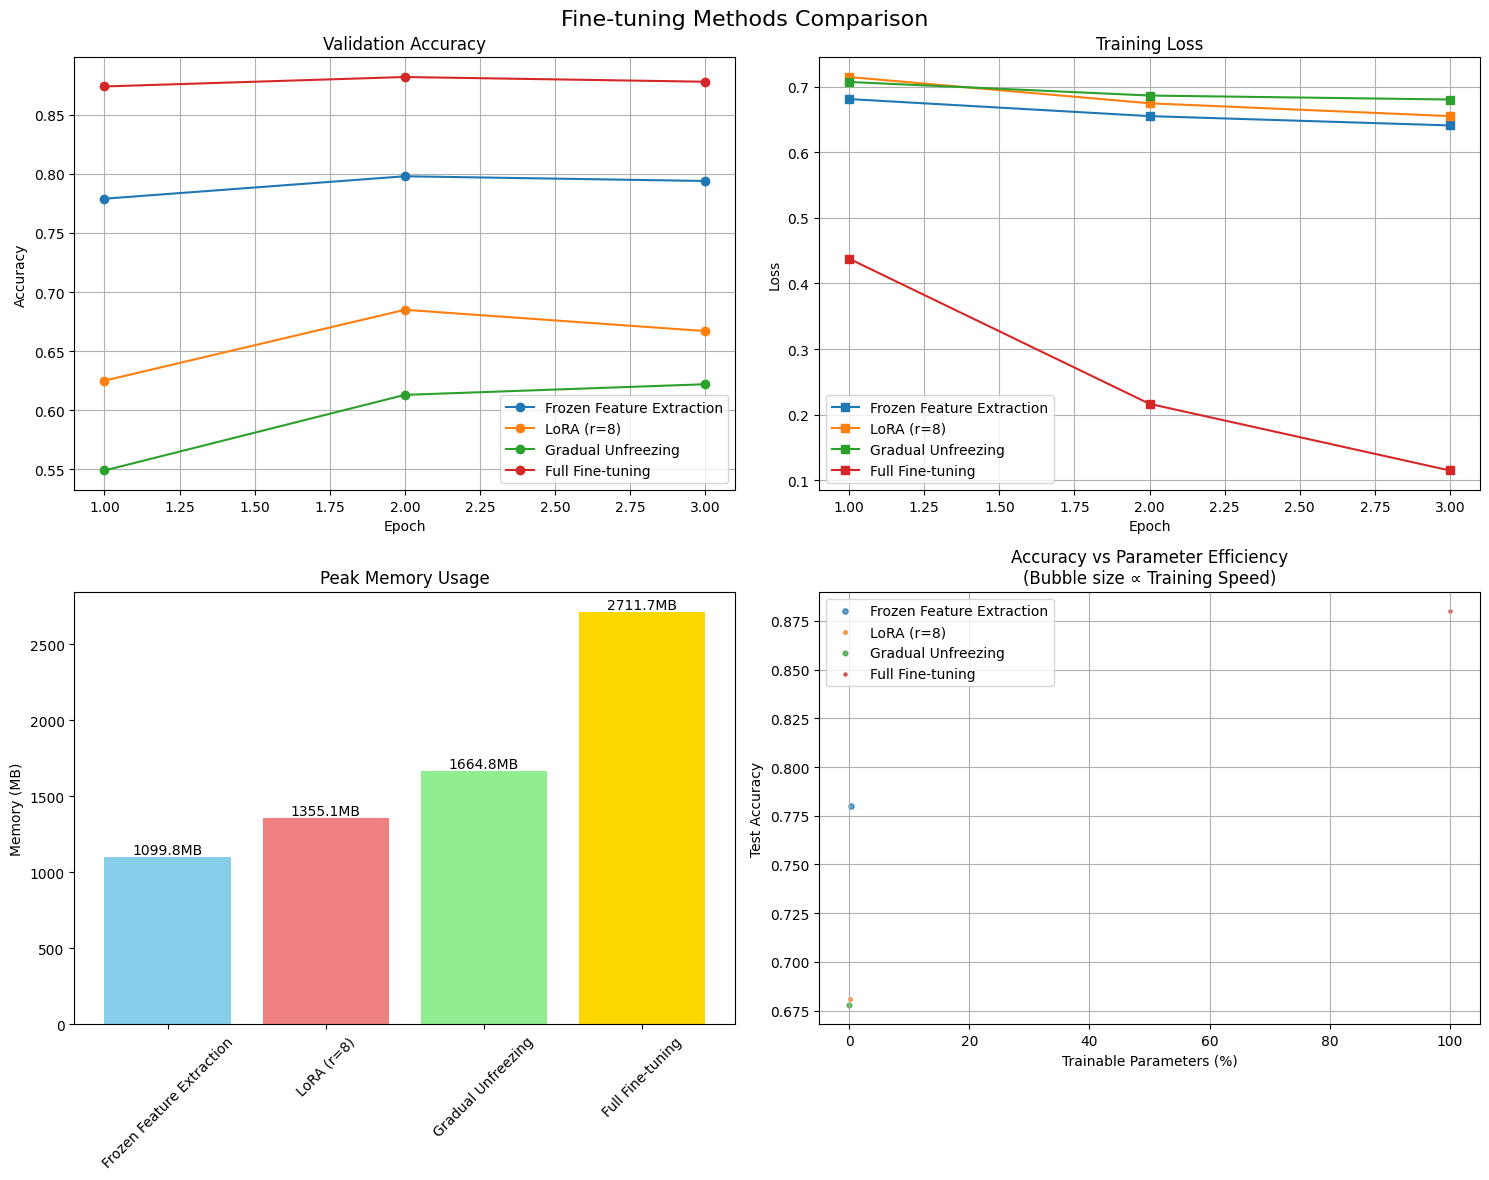


🎉 Experiment completed! Check the plots and analysis above.


In [13]:
# Example usage and demonstration
if __name__ == "__main__":
    # Initialize experiment
    experiment = SentimentAnalysisExperiment('distilbert-base-uncased')
    
    # Run all experiments
    print("Starting sentiment analysis fine-tuning experiments...")
    experiment.run_all_experiments()
    
    # Analyze results
    results_df = experiment.analyze_results()
    
    # Plot comparisons
    experiment.plot_training_curves()
    
    print("\n🎉 Experiment completed! Check the plots and analysis above.")